# This code replicates original SINDy as well as variants with different methods of optimization

Structure:
- Original SINDy Implementation
- Original LASSO Regression
- Base Proximal Optimization Algorithm
- SR3 Algorithm
- SR3 Applied to SINDy

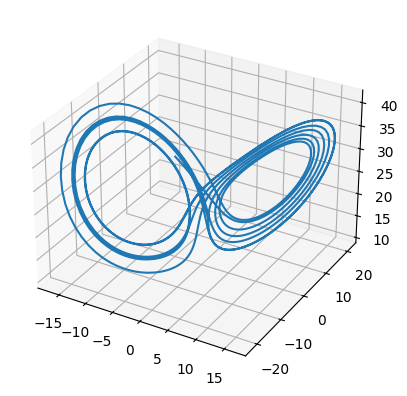

In [83]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import data_generator as dg

t, bigX, dX = dg.solve_lorenz_sys(10)
x, y, z = bigX.T
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(x, y, z)

In [77]:
bigX

array([[-8.        ,  7.        , 27.        ],
       [-6.57972563,  6.81474134, 25.79214919],
       [-5.31469862,  6.5849928 , 24.71972576],
       ...,
       [ 0.32762257,  1.46430614, 19.79084396],
       [ 0.43662562,  1.4820915 , 19.27514402],
       [ 0.53748915,  1.51101002, 18.77461404]])

In [78]:
from feature_maker import polynomial_features
features, feature_list, feature_name = polynomial_features(state_dim=3, order=3)
Phi = features(bigX)
Phi.shape

(1000, 20)

In [88]:
from regression_algs import vanilla_SINDy

fit = vanilla_SINDy(Phi, dX, prox_w=0.025, eps=1e-8)
fit

Array([[  0.       ,   0.       ,   0.       ],
       [-10.       ,  28.       ,   0.       ],
       [ 10.       ,  -1.       ,   0.       ],
       [  0.       ,   0.       ,  -2.6666667],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   1.       ],
       [  0.       ,  -1.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ]], dtype=float32)

In [37]:
import regression_algs as ra

C = jnp.eye(len(Phi[0]))
key, subkey = jax.random.split(jax.random.PRNGKey(0))
fit, _, prox_w = ra.SR3_CV(bigX, dX, features, C, 1, subkey, proximal_operator=ra.l1_prox_op, test_size=0.25, param_ranges=[0.0001, 10], resolution=100)
print(prox_w)

100%|██████████| 100/100 [00:03<00:00, 26.50it/s]

1e-04


In [84]:
# SR3 l0
C = jnp.eye(len(Phi[0]))
key, subkey = jax.random.split(jax.random.PRNGKey(0))
x_init = jax.random.normal(subkey, (Phi.shape[1], bigX.shape[1]))
fit, _ = ra.SR3(Phi, dX, C, ra.l0_prox_op, x_init, prox_w=0.05050505)

In [89]:
import numpy as np
import sympy as sy

def get_functions(fit, feature_name, disp=True):
    t = sy.Symbol('t')
    vars = [sy.Function(f'x{i}')(t) for i in range(fit.shape[1])]
    eqs = np.einsum('i, ij -> ij', feature_name, fit)
    eq_list = np.sum(eqs, axis=0)
    eq_list = [sy.Eq(sy.diff(vars[i], t), eq_list[i]) for i in range(fit.shape[1])]
    if disp:
        sy.init_printing(use_latex='mathjax')
        for eq in eq_list:
            display(eq)

    return eq_list

eq_list = get_functions(fit, feature_name)

d                             
──(x₀(t)) = -10.0⋅x₀ + 10.0⋅x₁
dt                            

d                                
──(x₁(t)) = -x₀⋅x₂ + 28.0⋅x₀ - x₁
dt                               

d                                          
──(x₂(t)) = 1.0⋅x₀⋅x₁ - 2.66666674613953⋅x₂
dt                                         

In [90]:
# Get list of state functions
def get_integrator(fit, feature_list):
    biginds = np.abs(fit) > 0

    lams = []
    for j in range(fit.shape[1]):
        inds = biginds.astype(int)[:, j]
        lam = []
        for i in range(fit.shape[0]):
            if inds[i]!=0:
                lam.append([fit[i, j], feature_list[i]])
        lamm = lambda x, lam=lam: sum([f[0]*f[1](x) for f in lam])
        lams.append(lamm)
    lams[0]([0, 1, 0])

    def integrator(t, x):
        dX = [lams[i](x) for i in range(len(lams))]
        return dX
    
    return integrator

integrator = get_integrator(fit, feature_list)

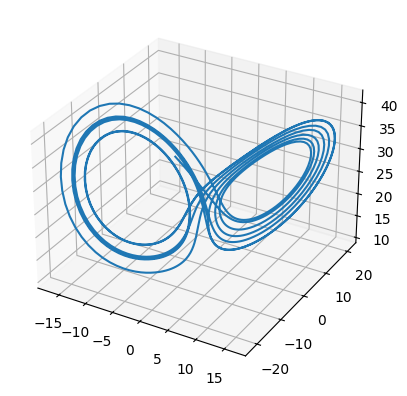

In [91]:
from scipy.integrate import solve_ivp

sol = solve_ivp(integrator, [0, 10], [-8.0, 7.0, 27.0], t_eval=np.linspace(0, 10, 1000))
x, y, z = sol.y

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot(x, y, z)
# plt.xlabel("$\sigma$")

Now, lets analyze how noise effects the system:

In [63]:
from regression_algs import SINDy_CV
from tqdm import tqdm

key, subkey = jax.random.split(jax.random.PRNGKey(0))
C = jnp.eye(len(Phi[0]))
x_init = jax.random.normal(subkey, (Phi.shape[1], bigX.shape[1]))

errors_vanilla = []
errors_sr3_l0 = []
errors_sr3_l1 = []
sigmas = np.linspace(0, 10, 200)
for sigma in tqdm(sigmas):
    key, key1, key2 = jax.random.split(key, 3)

    # Simulate dynamics
    t, bigX, dX = dg.solve_lorenz_sys(10, noise_sigma=sigma, seed=0)
    Phi = features(bigX)

    ## Vanilla SINDY
    fit = ra.vanilla_SINDy(Phi, dX, prox_w=0.025, eps=1e-8)
    # Get dynamics
    integrator = get_integrator(fit, feature_list)
    # Integrate
    sol = solve_ivp(integrator, [0, 10], [-8.0, 7.0, 27.0], t_eval=np.linspace(0, 10, 1000))
    error = jnp.linalg.norm(bigX - sol.y.T)
    errors_vanilla.append(error)

    ## SR3 l0
    # fit, _ = ra.SR3(Phi, dX, C, ra.l0_prox_op, x_init, prox_w=0.05050505)
    fit, _ = ra.SR3(Phi, dX, C, ra.l0_prox_op, x_init, prox_w=0.05050505)
    # Get dynamics
    integrator = get_integrator(fit, feature_list)
    # Integrate
    sol = solve_ivp(integrator, [0, 10], [-8.0, 7.0, 27.0], t_eval=np.linspace(0, 10, 1000))
    try:
        error = jnp.linalg.norm(bigX - sol.y.T)
        errors_sr3_l0.append(error)
    except:
        errors_sr3_l0.append(np.nan)

    ## SR3 l1
    fit, _ = ra.SR3(Phi, dX, C, ra.l1_prox_op, x_init, prox_w=0.0001)
    # Get dynamics
    integrator = get_integrator(fit, feature_list)
    # Integrate
    sol = solve_ivp(integrator, [0, 10], [-8.0, 7.0, 27.0], t_eval=np.linspace(0, 10, 1000))
    try:
        error = jnp.linalg.norm(bigX - sol.y.T)
        errors_sr3_l1.append(error)
    except:
        errors_sr3_l1.append(np.nan)

100%|██████████| 200/200 [02:24<00:00,  1.38it/s]


In [69]:
sum(np.isnan(errors_sr3_l1))/len(errors_sr3_l1)*100

4.0

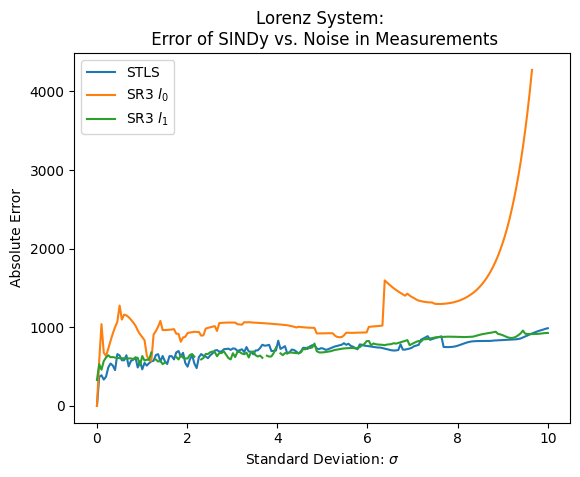

In [74]:
fig, ax = plt.subplots()
ax.plot(sigmas, errors_vanilla, label='STLS')  
ax.plot(sigmas, errors_sr3_l0, label='SR3 $l_0$')  
ax.plot(sigmas, errors_sr3_l1, label='SR3 $l_1$')  
# ax.set_yscale('log')

plt.title("Lorenz System: \n Error of SINDy vs. Noise in Measurements")
plt.xlabel("Standard Deviation: $\sigma$")
plt.ylabel("Absolute Error")
plt.legend()